# Fasttext tweet classification

## Data file creation

In [24]:
import datetime
import os
import pandas as pd
import random
import re
from nltk.tokenize import TweetTokenizer
from IPython.display import clear_output

In [25]:
TOPIC = "mondkapje"
FILETWEETS = TOPIC+"-tweets.csv"
FILEANNOTATIONS = "human-labels-"+TOPIC+"-tweets.txt"
FILEFASTTEXT = "fasttext-"+TOPIC+".csv"
LABELPREFIX = "__label__"
LARGEINT = 9999999999
LABEL = "label"
TEXT = "text"
USER = "user"

In [26]:
tweets = pd.read_csv(FILETWEETS,header=None,index_col=0)
annotations = pd.read_csv(FILEANNOTATIONS,header=None,sep=" ")

In [56]:
fasttextData = {}
for i in range(0,len(annotations)):
    tweetId = annotations.iloc[i][2]
    tweetLabel = annotations.iloc[i][4]
    if tweetId in list(tweets.index):
        tweetLabel = annotations.iloc[i][4]
        tweetUser = tweets.loc[tweetId][1]
        fasttextData[tweetId] = {LABEL:LABELPREFIX+tweetLabel,\
                                 USER:tweetUser,\
                                 TEXT:" ".join(TweetTokenizer().tokenize(tweets.loc[tweetId][2]))}

outFile = open(FILEFASTTEXT,"w")
seenTexts = {}
for tweetId in fasttextData:
    if not fasttextData[tweetId][TEXT] in seenTexts:
        print(fasttextData[tweetId][LABEL],fasttextData[tweetId][USER],fasttextData[tweetId][TEXT],file=outFile)
        seenTexts[fasttextData[tweetId][TEXT]] = True
outFile.close()

## Fasttext run and evaluation

In [57]:
import fasttext
from IPython.display import clear_output

In [58]:
PRETRAINEDDIR = "/home/erikt/projects/newsgac/fasttext-runs/"
WIKIFILENAME = "wiki.nl.vec"

In [59]:
def print_results(N, p, r):
    print("N\t" + str(N))
    print("P@{}\t{:.3f}".format(1, p))
    print("R@{}\t{:.3f}".format(1, r))

In [60]:
fasttextData = []
inFile = open(FILEFASTTEXT,"r")
for line in inFile: fasttextData.append(line.strip())
inFile.close()

In [61]:
DIM = 300
EPOCH = 100
LR = 0.1
N = 10
TRAIN = "TRAIN"+str(int(random.random()*LARGEINT))
TEST = "TEST"+str(int(random.random()*LARGEINT))

predictionCounts = []
predictionLabels = []
for fold in range(0,N):
    clear_output(wait=True)
    print("starting fold",fold)
    testStart = round(fold*len(fasttextData)/N)
    testEnd = round((fold+1)*len(fasttextData)/N)
    trainFile = open(TRAIN,"w")
    testFile = open(TEST,"w")
    testData = []
    for i in range(0,len(fasttextData)):
        if i < testStart or i >= testEnd: print(fasttextData[i],file=trainFile)
        else: 
            print(fasttextData[i],file=testFile)
            testData.append(fasttextData[i])
    testFile.close()
    trainFile.close()
    model = fasttext.train_supervised(TRAIN,dim=DIM,epoch=EPOCH,lr=LR) # ,pretrainedVectors=PRETRAINEDDIR+WIKIFILENAME)
    predictionCounts.append([*model.test(TEST)])
    predictionLabels.append(model.predict(testData))
    os.unlink(TRAIN)
    os.unlink(TEST)
clear_output(wait=True)
print("finished")

finished


In [62]:
caseTotal = 0
pTotal = 0
rTotal = 0
for i in range(0,len(predictionCounts)):
    caseTotal += predictionCounts[i][0]
    pTotal += predictionCounts[i][0]*predictionCounts[i][1]
    rTotal += predictionCounts[i][0]*predictionCounts[i][2]
print("cases: {0}; precision: {1}; recall: {2}".format(caseTotal,round(pTotal/caseTotal,3),round(rTotal/caseTotal,3)))

cases: 593; precision: 0.637; recall: 0.637


In [63]:
labelCountsGold = {}
for i in range(0,len(fasttextData)):
    label = fasttextData[i].split()[0]
    if label in labelCountsGold: labelCountsGold[label] += 1
    else: labelCountsGold[label] = 1

In [64]:
labelCountsGold

{'__label__NEUTRAL': 53,
 '__label__IRRELEVANT': 235,
 '__label__NEGATIVE': 273,
 '__label__POSITIVE': 32}

In [65]:
labelCountsPredicted = {}
for i in range(0,len(predictionLabels)):
    for label in predictionLabels[i][0]:
        if label[0] in labelCountsPredicted: labelCountsPredicted[label[0]] += 1
        else: labelCountsPredicted[label[0]] = 1

In [66]:
labelCountsPredicted

{'__label__NEUTRAL': 24,
 '__label__NEGATIVE': 330,
 '__label__IRRELEVANT': 235,
 '__label__POSITIVE': 4}

Fasttext predicts 63% of the labels correctly without external dictionary and 66% with a Wikipedia dictionary (baseline: 46%). It overestimates the presence of negative labels and underestimates the level of positive and neutral labels. The amount of irrelevant labels is about right

In [67]:
multiplicationFactors = {}
for label in labelCountsGold:
    multiplicationFactors[label] = labelCountsGold[label]/labelCountsPredicted[label]
multiplicationFactors

{'__label__NEUTRAL': 2.2083333333333335,
 '__label__IRRELEVANT': 1.0,
 '__label__NEGATIVE': 0.8272727272727273,
 '__label__POSITIVE': 8.0}

The multiplication factor for the positive label is unrealistically high so we will not use these factors.

In [68]:
predictedNumberOfLabels = 0
for label in labelCountsGold:
    predictedNumberOfLabels += multiplicationFactors[label]*labelCountsPredicted[label]
print(predictedNumberOfLabels,sum(labelCountsGold.values()))

593.0 593


## Classifying tweets

In [107]:
DATADIRECTORY = "/home/erikt/projects/puregome/data/text/"
NEGATIVE = "__label__NEGATIVE"
POSITIVE = "__label__POSITIVE"
NEUTRAL = "__label__NEUTRAL"
IRRELEVANT = "__label__IRRELEVANT"
TEXT = "text"
USER = "user"

In [ ]:
results = {}

In [ ]:
def readData(datePattern,query):
    fileList = sorted(os.listdir(DATADIRECTORY))
    tmpFileName = "classify."+str(int(random.random()*LARGEINT))+".txt"
    testData = []
    for inFileName in fileList:
        if re.search(datePattern,inFileName):
            os.system("gunzip -c "+DATADIRECTORY+inFileName+"| head -1 >"+tmpFileName)
            os.system("gunzip -c "+DATADIRECTORY+inFileName+"| grep \""+query+"\" >> "+tmpFileName)
            try: df = pd.read_csv(tmpFileName)
            except: continue
            for i in range(0,len(df)):
                if re.search(query,df.iloc[i][TEXT],flags=re.IGNORECASE):
                    testData.append(df.iloc[i][USER]+" "+df.iloc[i][TEXT])
    os.unlink(tmpFileName)
    return(testData)
    
def classify(datePattern,query):
    testData = readData(datePattern,query)
    model = fasttext.train_supervised(FILEFASTTEXT,dim=DIM,epoch=EPOCH,lr=LR) # ,pretrainedVectors=PRETRAINEDDIR+WIKIFILENAME)
    predictedLabels = model.predict(testData)
    predictedGroups = pd.DataFrame(predictedLabels[0]).groupby(0).groups
    labelCountsPredicted = {label:len(predictedGroups[label]) for label in predictedGroups}
    nbrOfLabels = sum([labelCountsPredicted[label] for label in labelCountsPredicted if label != IRRELEVANT])
    labelPercentages = { label:round(100*labelCountsPredicted[label]/nbrOfLabels,1) for label in labelCountsPredicted}
    return(labelPercentages)

In [174]:
QUERY = "mondkapje"

for month in "202002 202003 202004 202005 202006".split():
    for day in range(1,32):
        date = month+str(day).zfill(2)
        try:
            labels = classify(date,QUERY)
            results[date] = labels
            print(date,labels[NEGATIVE],labels[NEUTRAL],labels[POSITIVE],labels[IRRELEVANT])
        except: pass

20200201 68.2 15.3 16.5 142.4


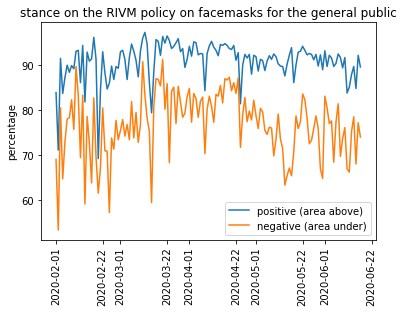

In [155]:
import matplotlib.pyplot as plt

DATEFORMAT = "%Y%m%d"

results ={k:results[k] for k in sorted(results.keys())}
plt.plot_date([datetime.datetime.strptime(k,DATEFORMAT) for k in results.keys()],\
              [labels[NEGATIVE]+labels[NEUTRAL] for labels in results.values()],\
              fmt="-",label="positive (area above)")
plt.plot_date([datetime.datetime.strptime(k,DATEFORMAT) for k in results.keys()],\
              [labels[NEGATIVE] for labels in results.values()],\
              fmt="-",label="negative (area under)")
plt.xticks(rotation="vertical")
plt.legend()
plt.title("stance on the RIVM policy on facemasks for the general public")
plt.ylabel("percentage")
plt.show()